In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/MyDrive/Pyspark/kaggle

/content/gdrive/MyDrive/Pyspark/kaggle


In [3]:
 pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
cp /content/gdrive/MyDrive/Pyspark/kaggle/kaggle.json  /root/.kaggle

In [7]:
! kaggle datasets download pavanelisetty/salarypredictions

 43% 10.0M/23.3M [00:00<00:00, 37.4MB/s]
100% 23.3M/23.3M [00:00<00:00, 72.9MB/s]


In [8]:
! unzip /content/gdrive/MyDrive/Pyspark/kaggle/salarypredictions.zip

Archive:  /content/gdrive/MyDrive/Pyspark/kaggle/salarypredictions.zip
  inflating: test_dataset.csv        
  inflating: train_dataset.csv       
  inflating: train_salaries.csv      


In [9]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 33 kB/s 
     |████████████████████████████████| 199 kB 33.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=1384c7f3c2d1f5e9d9710ddf79268d5662361bef3f0aa3d15cdde78148a000a3
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.style.use('ggplot')
sns.set_style('whitegrid')

from scipy import stats

from pyspark import SparkConf , SparkContext
from pyspark.sql import SparkSession , SQLContext

from pyspark.ml.feature import OneHotEncoder , VectorAssembler , VectorIndexer , StringIndexer , IndexToString
from pyspark.ml import Pipeline

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

In [13]:
my_spark = SparkSession.builder.getOrCreate()
my_spark

In [15]:
sqlContext = SQLContext(my_spark.sparkContext)
sqlContext

In [16]:
# Dataset Loading and First Analysis

In [18]:
df1 = my_spark.read.csv("/content/gdrive/MyDrive/Pyspark/kaggle/train_dataset.csv", header=True).cache()

In [19]:
df2 = my_spark.read.csv("/content/gdrive/MyDrive/Pyspark/kaggle/train_salaries.csv",header=True).cache()

In [20]:
df1.show(5)

+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|           jobId|companyId|       jobType|     degree|    major|industry|yearsExperience|milesFromMetropolis|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|  HEALTH|             10|                 83|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|     WEB|              3|                 73|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|  PHYSICS|  HEALTH|             10|                 38|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL|CHEMISTRY|    AUTO|              8|                 17|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|  PHYSICS| FINANCE|              8|                 16|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
o

In [21]:
df2.show()

+----------------+------+
|           jobId|salary|
+----------------+------+
|JOB1362684407687|   130|
|JOB1362684407688|   101|
|JOB1362684407689|   137|
|JOB1362684407690|   142|
|JOB1362684407691|   163|
|JOB1362684407692|   113|
|JOB1362684407693|   178|
|JOB1362684407694|    73|
|JOB1362684407695|    31|
|JOB1362684407696|   104|
|JOB1362684407697|   102|
|JOB1362684407698|   144|
|JOB1362684407699|    79|
|JOB1362684407700|   193|
|JOB1362684407701|    47|
|JOB1362684407702|   172|
|JOB1362684407703|    47|
|JOB1362684407704|   126|
|JOB1362684407705|   122|
|JOB1362684407706|    95|
+----------------+------+
only showing top 20 rows



In [22]:
df1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: string (nullable = true)
 |-- milesFromMetropolis: string (nullable = true)



In [23]:
df2.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: string (nullable = true)




By printing the df schema, we can see that some features such as salary, yearsExperience and milesFromMetropolis should be converted to integer type!

In [25]:
df1 = df1.withColumn("yearsExperience",df1.yearsExperience.cast("int"))
df1 = df1.withColumn("milesFromMetropolis",df1.milesFromMetropolis.cast("int"))

In [26]:
df2 = df2.withColumn("salary",df2.salary.cast("int"))

In [27]:
df2.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: integer (nullable = true)



In [28]:
df2= df2.withColumnRenamed('jobId', 'job_id')                                             

In [29]:
df = df1.join(df2 , df1.jobId == df2.job_id)

In [30]:
df= df.drop('job_id')

In [31]:
df.show()

+----------------+---------+--------------+-----------+----------+---------+---------------+-------------------+------+
|           jobId|companyId|       jobType|     degree|     major| industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+--------------+-----------+----------+---------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|      MATH|   HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|      NONE|      WEB|              3|                 73|   101|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL| CHEMISTRY|     AUTO|              8|                 17|   142|
|JOB1362684407693|   COMP15|           CFO|       NONE|      NONE|   HEALTH|             23|                 24|   178|
|JOB1362684407694|   COMP24|        JUNIOR|  BACHELORS| CHEMISTRY|EDUCATION|              9|                 70|    73|
|JOB1362684407695|   COMP20|       JANIT

# Duplicated Data Check

In [32]:
df_dup = df.groupBy('yearsExperience','milesFromMetropolis','companyId',"jobType", "degree", "major", "industry", "jobId").count().filter('count > 1')

In [33]:
df_dup.drop('count').show()  

+---------------+-------------------+---------+-------+------+-----+--------+-----+
|yearsExperience|milesFromMetropolis|companyId|jobType|degree|major|industry|jobId|
+---------------+-------------------+---------+-------+------+-----+--------+-----+
+---------------+-------------------+---------+-------+------+-----+--------+-----+



# Missing Value Check

In [34]:
df.show(10)

+----------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+
|           jobId|companyId|       jobType|     degree|    major| industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|   HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|      WEB|              3|                 73|   101|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL|CHEMISTRY|     AUTO|              8|                 17|   142|
|JOB1362684407693|   COMP15|           CFO|       NONE|     NONE|   HEALTH|             23|                 24|   178|
|JOB1362684407694|   COMP24|        JUNIOR|  BACHELORS|CHEMISTRY|EDUCATION|              9|                 70|    73|
|JOB1362684407695|   COMP20|       JANITOR|HIGH_

In [36]:
print("Number of Missing Values for jobtype: {}".format(df.filter(df.jobType=='NONE').count()))
print("Number of Missing Values for degree: {}".format(df.filter(df.degree=='NONE').count()))
print("Number of Missing Values for major : {}".format(df.filter(df.major =='NONE').count()))
print("Number of Missing Values for industry: {}".format(df.filter(df.industry=='NONE').count()))

Number of Missing Values for jobtype: 0
Number of Missing Values for degree: 236854
Number of Missing Values for major : 532355
Number of Missing Values for industry: 0


they are not missing values! They indicate that the worker do not have a degree or major for example. We won't drop these values

# Dataset Analysis

In [37]:
# Analyzing Numerical Columns
df.describe(['yearsExperience','milesFromMetropolis','salary']).show()                                                                                                 

+-------+-----------------+-------------------+-----------------+
|summary|  yearsExperience|milesFromMetropolis|           salary|
+-------+-----------------+-------------------+-----------------+
|  count|          1000000|            1000000|          1000000|
|   mean|        11.992386|           49.52926|       116.061818|
| stddev|7.212390868885708| 28.877732628720178|38.71793638113286|
|    min|                0|                  0|                0|
|    max|               24|                 99|              301|
+-------+-----------------+-------------------+-----------------+



from this we can say that minim salary is 0. This may be related to Volunteering job

# Finding Highest Paid Job

In [39]:
df.createOrReplaceTempView("data")

In [41]:
my_spark.sql('''
SELECT salary , jobtype , industry 
from data
where salary == (select MAX(salary) FROM data)
''').show()

+------+-------+--------+
|salary|jobtype|industry|
+------+-------+--------+
|   301|    CFO|     OIL|
|   301|    CTO|     OIL|
+------+-------+--------+



In [42]:
#  The Highest Paid Jobs are CFO and CTO in OIL industry, with a salary of 301k$

# Top 20 jobs in terms of Highest Salary

In [44]:
df_sal20 = my_spark.sql('''
SELECT salary , jobtype , industry , RANK() OVER(PARTITION BY industry ORDER BY salary DESC) Rank
from data
ORDER BY Salary DESC
LIMIT 28
''')
df_sal20.show(20)

+------+-------+--------+----+
|salary|jobtype|industry|Rank|
+------+-------+--------+----+
|   301|    CFO|     OIL|   1|
|   301|    CTO|     OIL|   1|
|   298|    CEO|     OIL|   3|
|   294|    CEO|     OIL|   4|
|   294|    CEO| FINANCE|   1|
|   293|    CEO|     OIL|   5|
|   293|    CEO| FINANCE|   2|
|   292|    CEO| FINANCE|   3|
|   292|    CTO| FINANCE|   3|
|   290|    CEO|     WEB|   1|
|   289|    CFO|     OIL|   6|
|   289|    CTO|     WEB|   2|
|   289|    CEO| FINANCE|   5|
|   288|    CFO| FINANCE|   6|
|   288|    CFO| FINANCE|   6|
|   287|    CEO|     OIL|   7|
|   287|    CEO| FINANCE|   8|
|   286|    CEO|     OIL|   8|
|   286|    CTO| FINANCE|   9|
|   286|    CEO| FINANCE|   9|
+------+-------+--------+----+
only showing top 20 rows



From this we can infer that top salary jobs are in OIL and Finance industry

# Least Paid Job

In [46]:
my_spark.sql('''
SELECT salary, jobtype , industry , RANK() OVER(PARTITION BY industry order by salary asc)Rank
from data
order by salary asc
''').show()

+------+--------------+---------+----+
|salary|       jobtype| industry|Rank|
+------+--------------+---------+----+
|     0|           CTO|     AUTO|   1|
|     0|        JUNIOR|      OIL|   1|
|     0|VICE_PRESIDENT|      WEB|   1|
|     0|        JUNIOR|     AUTO|   1|
|     0|       MANAGER|  FINANCE|   1|
|    17|       JANITOR|EDUCATION|   1|
|    18|       JANITOR|EDUCATION|   2|
|    18|       JANITOR|EDUCATION|   2|
|    18|       JANITOR|EDUCATION|   2|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    20|       JANITOR|EDUCATION|  15|
+------+--------------+---------+----+
only showing top 20 rows



from this we can infer that 0 salary are missing values. from early queries we have seen that OIL ,WEB and FINANCE industry are well piad in Industry. Also if we see Job type there job designation are CTO, VICE PRESIDENT AND MANAGER, so it is impossible that they will have 0$ salary. We will drop these values

In [47]:
df = df.where("salary !=0")

In [49]:
# Then , we also need to reload the table since we updataed the dataframe df.

In [50]:
df.createOrReplaceTempView('data')

# Lowest Salary Industry

In [51]:
df_ind= my_spark.sql('''
Select salary , jobtype , industry , rank() over(partition by industry order by salary asc) Rank
from data
order by salary asc
''')

In [52]:
df_ind.show()

+------+-------+---------+----+
|salary|jobtype| industry|Rank|
+------+-------+---------+----+
|    17|JANITOR|EDUCATION|   1|
|    18|JANITOR|EDUCATION|   2|
|    18|JANITOR|EDUCATION|   2|
|    18|JANITOR|EDUCATION|   2|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
+------+-------+---------+----+
only showing top 20 rows



In [53]:
# from this we can infer that the lowest paid job is Janitor with a salary of 17K$

# Top Industry in terms of Highest Salary

In [54]:
df_topind = my_spark.sql('''
Select industry ,avg(salary) as average_salary
from data
group by industry
order by average_salary desc
''')

In [55]:
df_topind.show()

+---------+------------------+
| industry|    average_salary|
+---------+------------------+
|      OIL|130.95386285634237|
|  FINANCE|  130.747658645164|
|      WEB| 121.6453615446388|
|   HEALTH| 115.7355399110364|
|     AUTO|109.43522152496485|
|  SERVICE|104.44682029458984|
|EDUCATION| 99.44838571898697|
+---------+------------------+



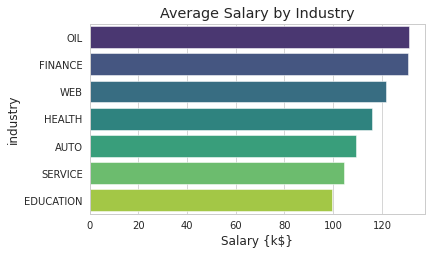

In [61]:
df_p = df_topind.toPandas()
plt.figure(figsize=(6,3.5))
sns.barplot(y="industry", x = "average_salary", data= df_p , palette = 'viridis')
plt.title("Average Salary by Industry")
plt.xlabel("Salary {k$}")
plt.show()

from this  we can infer that the top industry are  Oil and Finance, and also they are having a very similar average salary of 130 k$. The Third industry according is web in highest salary pay.

# Checking workers with more years of Experience get paid more

In [62]:
df_exp = my_spark.sql('''
Select salary , jobtype , industry , yearsExperience
from data 
order by salary DESC
''')                                                                           

In [63]:
df_exp.show()

+------+-------+--------+---------------+
|salary|jobtype|industry|yearsExperience|
+------+-------+--------+---------------+
|   301|    CFO|     OIL|             23|
|   301|    CTO|     OIL|             24|
|   298|    CEO|     OIL|             22|
|   294|    CEO| FINANCE|             24|
|   294|    CEO|     OIL|             19|
|   293|    CEO|     OIL|             24|
|   293|    CEO| FINANCE|             16|
|   292|    CEO| FINANCE|             22|
|   292|    CTO| FINANCE|             24|
|   290|    CEO|     WEB|             20|
|   289|    CTO|     WEB|             24|
|   289|    CFO|     OIL|             23|
|   289|    CEO| FINANCE|             23|
|   288|    CFO| FINANCE|             24|
|   288|    CFO| FINANCE|             21|
|   287|    CEO| FINANCE|             19|
|   287|    CEO|     OIL|             22|
|   286|    CEO| FINANCE|             24|
|   286|    CTO| FINANCE|             24|
|   286|    CEO|     OIL|             16|
+------+-------+--------+---------

In [64]:
# Count the different jobtypes in the Dataframe
df_exp.groupby('jobtype').count().show()

+--------------+------+
|       jobtype| count|
+--------------+------+
|           CTO|125045|
|        JUNIOR|124592|
|       JANITOR|124971|
|           CFO|124369|
|           CEO|124778|
|       MANAGER|125120|
|VICE_PRESIDENT|125234|
|        SENIOR|125886|
+--------------+------+



In [65]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR','JANITOR']

In [67]:
df_p = df_exp.toPandas()

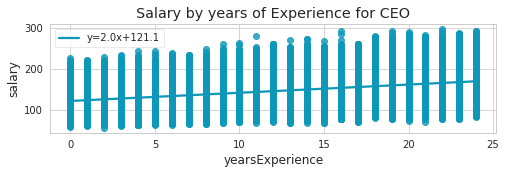

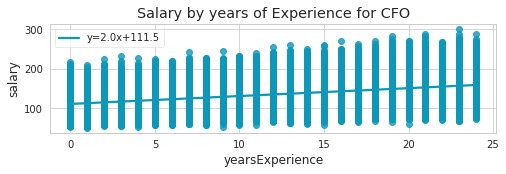

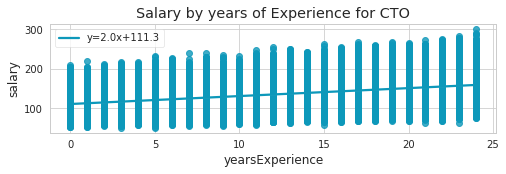

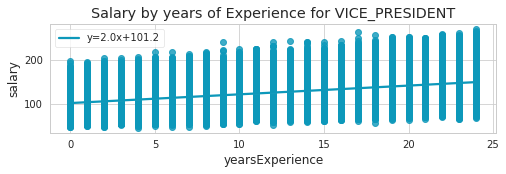

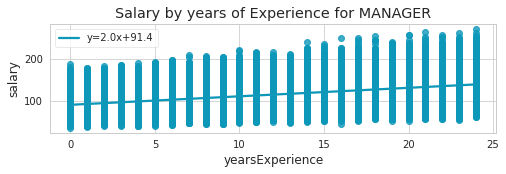

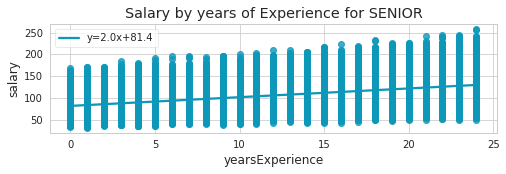

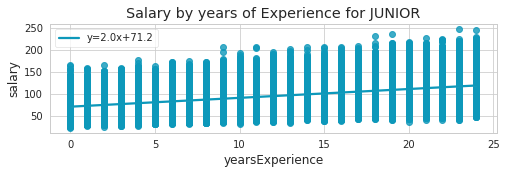

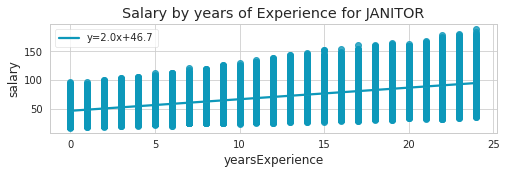

In [73]:
slope_list =[]
intercept_list=[]
for job in job_list:
  df_x = df_p.loc[df_p['jobtype']==job]
  slope, intercept , r_value , p_value , std_err = stats.linregress(df_x['yearsExperience'] , df_x['salary'])
  slope_list.append(slope)
  intercept_list.append(intercept)
  plt.figure(figsize=(8,2))
  sns.regplot(x='yearsExperience', y = 'salary', data=df_x, color='#0d98ba', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
  plt.legend()
  plt.title("Salary by years of Experience for " + job)
  plt.show()

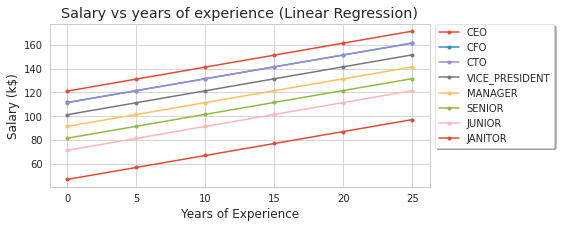

In [75]:
X = np.array([0, 5, 10, 15, 20, 25])
plt.figure(figsize=(6.8,3))
for i in range(8):
    plt.plot(X, slope_list[i]*X+intercept_list[i],label=job_list[i], marker='.')
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fancybox=True, shadow=True)
plt.ylabel('Salary (k$)')
plt.xlabel('Years of Experience')
plt.title('Salary vs years of experience (Linear Regression)')
plt.show()

We can see an increasing trend between years of experience and salary among all different jobs: this means that more years of experience lead to higher salaries for all the job positions. By looking at the slope and intercept for each linear model, we can see that the slope is rounded to 2.0 for all the positions: this means that, on average, all these jobs see an increase of salary by 2000$ annually. 



# Workers with Higer Degree are better paid or not

In [78]:
 df_deg = my_spark.sql('''
 select degree , salary , jobtype from data order by salary
  ''')

In [79]:
df_deg.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       NONE|    17|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       NONE|    18|JANITOR|
|       NONE|    19|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [84]:
# None are missing value so we will drop them
df_deg = df_deg.replace('NONE',None)
df_deg.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       null|    17|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       null|    18|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [85]:
df_deg = df_deg.na.drop()

In [86]:
df_deg.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|HIGH_SCHOOL|    20|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [88]:
df_deg.groupBy('degree').count().show()

+-----------+------+
|     degree| count|
+-----------+------+
|  BACHELORS|175495|
|    MASTERS|175310|
|HIGH_SCHOOL|236975|
|   DOCTORAL|175362|
+-----------+------+



In [89]:
degrees_list = ['HIGH_SCHOOL','BACHELORS','DOCTORAL','MASTERS']

In [90]:
df_p = df_deg.toPandas()

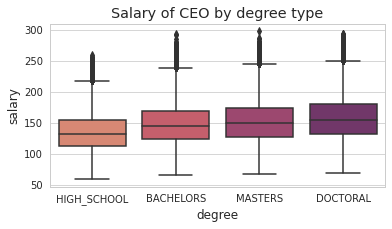

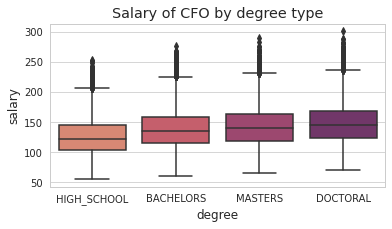

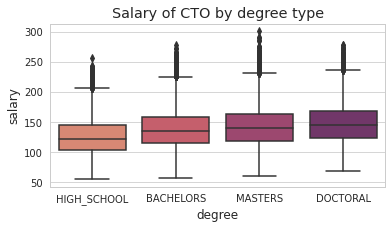

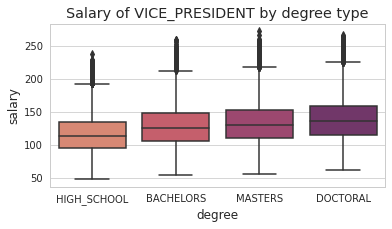

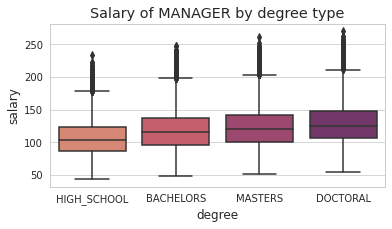

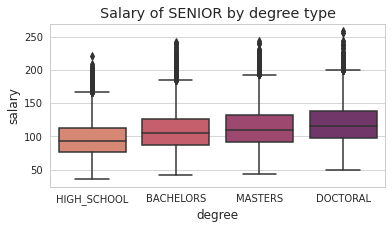

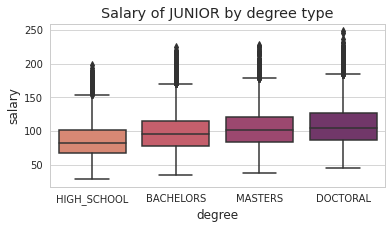

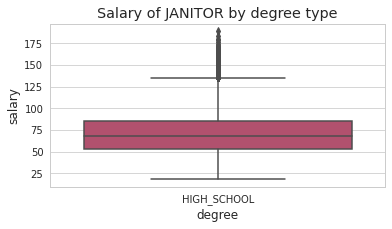

In [94]:
for job in job_list:
  df_x = df_p.loc[df_p['jobtype']==job]
  plt.figure(figsize= (6,3))
  sns.boxplot(x='degree', y='salary', data=df_x, palette='flare')
  plt.title('Salary of '+ job + ' by degree type')
  plt.show()

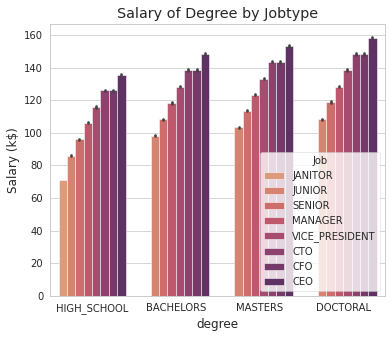

In [95]:
plt.figure(figsize= (6,5))
sns.barplot(x = 'degree', y= 'salary', data= df_p , hue = 'jobtype', palette='flare')
plt.legend(loc='lower right', title = 'Job')
plt.ylabel('Salary (k$)')
plt.title('Salary of Degree by Jobtype')
plt.show()

 from this we can infer that higher degree employees are paid well. We can clearly see the difference is high between High School and Bachelors.
it interesting to notice that in case of JANITOR as a jobtype, there are only people with a High school education.

# Checking Major affects the Salary or Not

In [97]:
df_major = my_spark.sql('''
select jobtype , degree , major , salary from data order by salary
''')

In [98]:
df_major.show(5)

+-------+-----------+-----+------+
|jobtype|     degree|major|salary|
+-------+-----------+-----+------+
|JANITOR|       NONE| NONE|    17|
|JANITOR|HIGH_SCHOOL| NONE|    18|
|JANITOR|HIGH_SCHOOL| NONE|    18|
|JANITOR|       NONE| NONE|    18|
|JANITOR|       NONE| NONE|    19|
+-------+-----------+-----+------+
only showing top 5 rows



In [99]:
# None are missing values so we will drop it
df_major = df_major.replace('NONE',None)
df_major = df_major.na.drop()

In [100]:
df_major.show()

+-------+---------+-----------+------+
|jobtype|   degree|      major|salary|
+-------+---------+-----------+------+
| JUNIOR|BACHELORS|    BIOLOGY|    35|
| JUNIOR|BACHELORS| LITERATURE|    37|
| JUNIOR|BACHELORS| LITERATURE|    37|
| JUNIOR|BACHELORS|    PHYSICS|    38|
| JUNIOR|BACHELORS|    BIOLOGY|    38|
| JUNIOR|BACHELORS|       MATH|    39|
| JUNIOR|BACHELORS|  CHEMISTRY|    40|
| JUNIOR|BACHELORS|   BUSINESS|    40|
| JUNIOR|BACHELORS|    BIOLOGY|    40|
| JUNIOR|BACHELORS|  CHEMISTRY|    40|
| JUNIOR|  MASTERS|  CHEMISTRY|    40|
| JUNIOR|  MASTERS| LITERATURE|    41|
| JUNIOR|BACHELORS|   BUSINESS|    41|
| JUNIOR|BACHELORS|    PHYSICS|    41|
| JUNIOR|BACHELORS|    COMPSCI|    41|
| JUNIOR|BACHELORS|  CHEMISTRY|    41|
| JUNIOR|BACHELORS|    PHYSICS|    41|
| JUNIOR|BACHELORS|       MATH|    41|
| JUNIOR|BACHELORS|ENGINEERING|    41|
| JUNIOR|BACHELORS|    BIOLOGY|    41|
+-------+---------+-----------+------+
only showing top 20 rows



In [101]:
df_major.groupby('major').count().show()

+-----------+-----+
|      major|count|
+-----------+-----+
|    BIOLOGY|58379|
|ENGINEERING|58594|
|    PHYSICS|58410|
|  CHEMISTRY|58875|
|   BUSINESS|58518|
|       MATH|57800|
|    COMPSCI|58382|
| LITERATURE|58684|
+-----------+-----+



In [102]:
df_major.groupby('jobtype').count().show()

+--------------+-----+
|       jobtype|count|
+--------------+-----+
|           CTO|66885|
|        JUNIOR|66465|
|           CFO|66427|
|           CEO|66754|
|       MANAGER|66832|
|VICE_PRESIDENT|66771|
|        SENIOR|67508|
+--------------+-----+



In [103]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR']

In [105]:
df_p = df_major.toPandas()

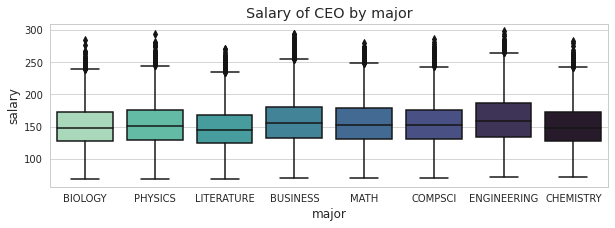

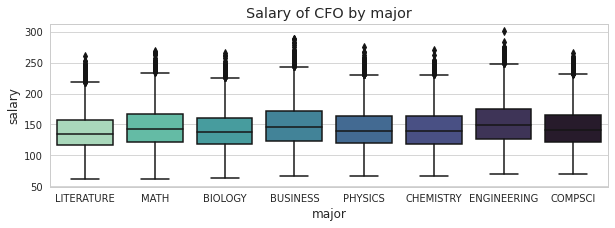

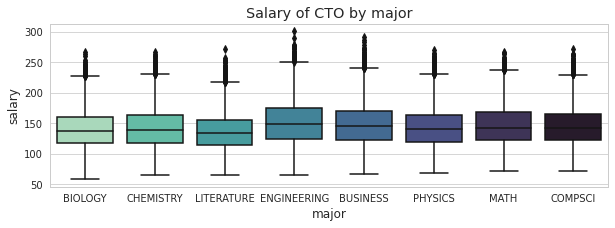

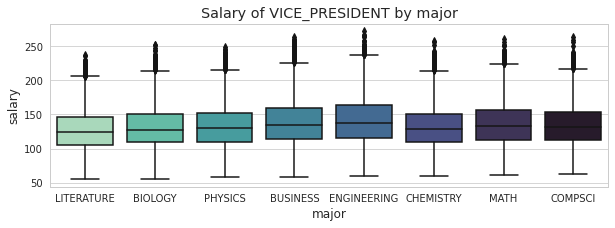

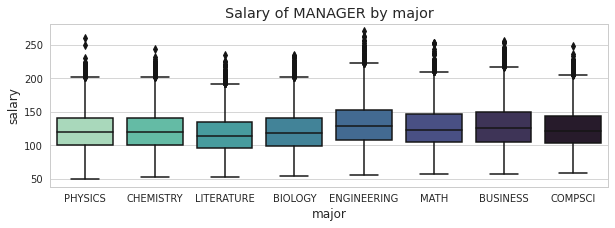

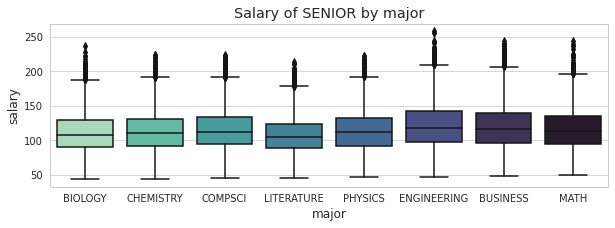

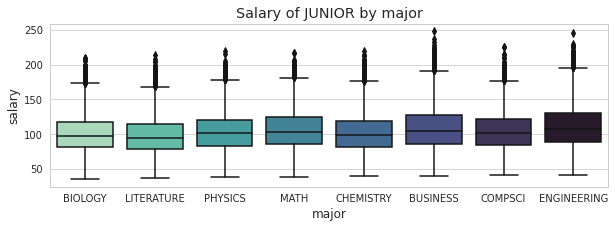

In [108]:
for job in job_list:
  df_x = df_p.loc[df_p['jobtype']==job]
  plt.figure(figsize=(10,3))
  sns.boxplot(x='major', y='salary', data= df_x, palette = 'mako_r')
  plt.title('Salary of ' + job + ' by major')
  plt.show()

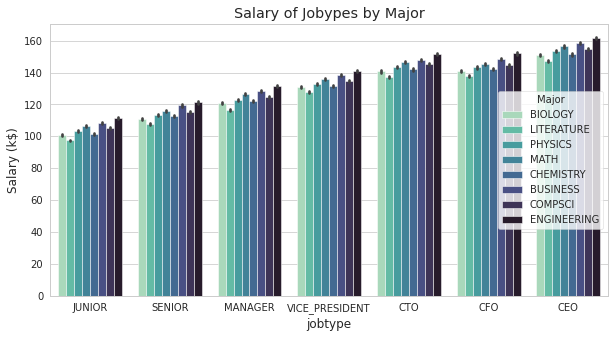

In [109]:
plt.figure(figsize = (10,5))
sns.barplot(x='jobtype',y='salary', data= df_p , hue='major', palette='mako_r')
plt.legend(loc = 'center right', title= 'Major')
plt.ylabel('Salary (k$)')
plt.title('Salary of Jobypes by Major')
plt.show()

We can see that engineering is the major the major of workers with higher salaries, business is the second and while literature is the major of workers with the lowest paid jobs.

# Machine Learning

In [110]:
df.show(5)

+----------------+---------+-------+-----------+---------+---------+---------------+-------------------+------+
|           jobId|companyId|jobType|     degree|    major| industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+-------+-----------+---------+---------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|    CFO|    MASTERS|     MATH|   HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|    CEO|HIGH_SCHOOL|     NONE|      WEB|              3|                 73|   101|
|JOB1362684407690|   COMP38|MANAGER|   DOCTORAL|CHEMISTRY|     AUTO|              8|                 17|   142|
|JOB1362684407693|   COMP15|    CFO|       NONE|     NONE|   HEALTH|             23|                 24|   178|
|JOB1362684407694|   COMP24| JUNIOR|  BACHELORS|CHEMISTRY|EDUCATION|              9|                 70|    73|
+----------------+---------+-------+-----------+---------+---------+---------------+-------------------+

In [111]:
# we will create a copy of the dataframe called 'df_encoded', which will include the pre processed data.

In [112]:
df_encoded= df.alias('df_encoded')
id(df_encoded) == id(df)

False

In [113]:
# removing job_id
df_encoded = df_encoded.drop('jobId')

In [115]:
cols= df_encoded.columns

In [117]:
# Analyze the Target Variable Salary
salary_df= df_encoded.select('salary').toPandas()

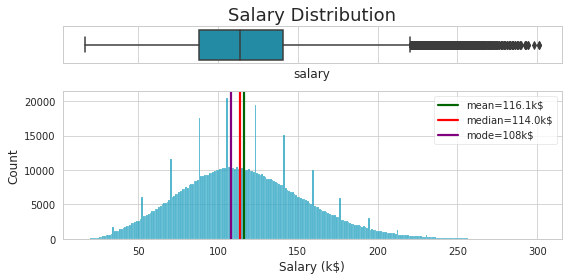

In [118]:
fig ,ax = plt.subplots(2,1,sharex=True, figsize=(8,4), gridspec_kw={"height_ratios":(.2 , .8)})
ax[0].set_title('Salary Distribution',fontsize=18)
sns.boxplot(x='salary', data = salary_df , ax= ax[0] , color= '#0d98ba')
ax[0].set(yticks=[])
sns.histplot(x='salary',data=salary_df,ax=ax[1],color='#0d98ba')
plt.axvline(salary_df['salary'].mean(), color='darkgreen', linewidth=2.2, label='mean=' + str(np.round(salary_df['salary'].mean(),1)) + 'k$')
plt.axvline(salary_df['salary'].median(), color='red', linewidth=2.2, label='median='+ str(np.round(salary_df['salary'].median(),1)) + 'k$')
plt.axvline(salary_df['salary'].mode()[0], color='purple', linewidth=2.2, label='mode='+ str(salary_df['salary'].mode()[0]) + 'k$')
ax[1].set_xlabel('Salary (k$)')
plt.legend()
plt.tight_layout()
plt.show()


Salary feature has a right skewed long tail distributions

# Label Encoding

In [119]:
categoricalColumns = ["companyId","jobType", "degree", "major", "industry"]
stages = []
for categoricalCol in categoricalColumns:
  stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index')
  stages += [stringIndexer]
numericCols = ["yearsExperience","milesFromMetropolis"]
assemblerInputs = [c + "Index" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols = assemblerInputs,outputCol = "features")
stages +=[assembler]

In [122]:
# In this dataset, the only categorical feature where there is a hieracrhy/order is degree, 
#so we should encode this feature with label encoding.

In [123]:
stages = []
stringIndexer= StringIndexer(inputCol = "degree", outputCol = "degreeIndex")
stages += [stringIndexer]

In [124]:
stages

[StringIndexer_86b9860a88a3]

In [125]:
# we improve the R2 by 0.8% by encoding 'degree' with label encoding instead of one hot encoding.

# One-Hot Encoding

In [126]:
categoricalColumns = ["companyId","jobType", "major", "industry"]
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()],outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
numericCols = ["yearsExperience", "milesFromMetropolis"]
assemblerInputs= [c + "classVec" for c in categoricalColumns] + numericCols + ["degreeIndex"]
assembler = VectorAssembler(inputCols = assemblerInputs,outputCol="features")
stages += [assembler]

In [128]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_encoded)
df_encoded = pipelineModel.transform(df_encoded)
selectCols = ['features'] + cols
df_encoded = df_encoded.select(selectCols)

In [129]:
df_encoded.show(2)

+--------------------+---------+-------+-----------+-----+--------+---------------+-------------------+------+
|            features|companyId|jobType|     degree|major|industry|yearsExperience|milesFromMetropolis|salary|
+--------------------+---------+-------+-----------+-----+--------+---------------+-------------------+------+
|(86,[29,82,83,84,...|   COMP37|    CFO|    MASTERS| MATH|  HEALTH|             10|                 83|   130|
|(86,[13,67,69,77,...|   COMP19|    CEO|HIGH_SCHOOL| NONE|     WEB|              3|                 73|   101|
+--------------------+---------+-------+-----------+-----+--------+---------------+-------------------+------+
only showing top 2 rows



We can see the presence of a "features" column, including all the different encoded features by one hot encoding and the numerical features. This column 'featurs' and the target column 'salary' will be passed to the ML algorithm during the training.

# Train Test Split

In [132]:
train , test = df_encoded.randomSplit([0.995,0.005],seed=99)
print("There are %d training examples and %d test examples"%(train.count(), test.count()))

There are 994960 training examples and 5035 test examples


#  Gradient Boosting Regressor

In [136]:
gb = GBTRegressor(featuresCol="features", labelCol ="salary",maxBins=20,maxDepth=12)

In [137]:
gb_model= gb.fit(train)

In [138]:
predictions = gb_model.transform(test)

# Prediction Results

In [139]:
evaluator = RegressionEvaluator(labelCol ="salary",predictionCol="prediction", metricName ="rmse")
rmse = evaluator.evaluate(predictions)
rmse

19.528561597104638

In [140]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
r2

0.7518986903170999

In [141]:
rf_results = predictions.toPandas()

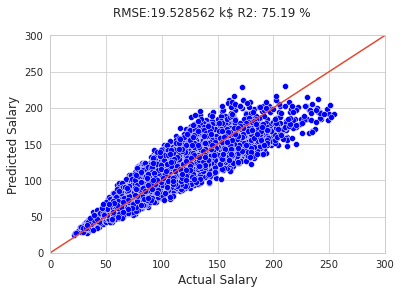

In [143]:
sns.scatterplot(x='salary', y='prediction', data=rf_results, color='blue')
plt.plot([0,300],[0,300])
plt.axis([0,300,0,300])
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.suptitle("RMSE:{:2f} k$ R2: {:.2f} %".format(rmse , r2*100))
plt.show()

In [144]:
print("RMSE: {:.2f} k$ \nR2: {:.2f} %".format(rmse, r2*100))

RMSE: 19.53 k$ 
R2: 75.19 %


We can see that the algorithm predicts better salaries lower than 130k$, and start to understimate salaries over 175k\$. This could be due to the right skeweness of the salary distribution.
Overall, the results are satifying in both terms of RMSE and R2. Further improvements could be achieved by a proper hyperparameter tuning and feature engineering on the data.

In [149]:
gb_model.save("model.pkl")

In [150]:
my_spark.stop()